<a href="https://colab.research.google.com/github/keto08/covid-19/blob/master/south_korea_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

### Data Loading

In [219]:
url = 'https://raw.githubusercontent.com/keto08/covid-19/master/korea_patient_info.csv'
df = pd.read_csv(url)
df

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,female,30s,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,25,NaN,2020-05-30,2020-06-13,NaN,released
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaN,NaN,isolated
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaN,NaN,isolated


### Data Exploration

In [220]:
df.shape

(5165, 14)

In [221]:
df.patient_id.nunique()

5164

In [222]:
df.infected_by.count()

1346

In [223]:
df.infection_case.value_counts()

contact with patient                             1610
overseas inflow                                   840
etc                                               703
Itaewon Clubs                                     162
Richway                                           128
Guro-gu Call Center                               112
Shincheonji Church                                107
Coupang Logistics Center                           80
Yangcheon Table Tennis Club                        44
Day Care Center                                    43
SMR Newly Planted Churches Group                   36
Onchun Church                                      33
Bonghwa Pureun Nursing Home                        31
gym facility in Cheonan                            30
Ministry of Oceans and Fisheries                   28
Wangsung Church                                    24
Cheongdo Daenam Hospital                           21
Dongan Church                                      17
Eunpyeong St. Mary's Hospita

In [224]:
df.contact_number.count()

791

In [225]:
df.contact_number.value_counts()

3       96
2       92
1       87
0       83
4       51
        ..
32       1
1091     1
64       1
95       1
185      1
Name: contact_number, Length: 88, dtype: int64

In [226]:
df.infected_by.value_counts()

2000000205    51
4100000008    27
1400000209    24
2000000167    24
2000000309    21
              ..
1100000100     1
2000000150     1
1000000140     1
4100000023     1
2000000227     1
Name: infected_by, Length: 606, dtype: int64

In [227]:
df.sex.value_counts()

female    2218
male      1825
Name: sex, dtype: int64

In [228]:
df.age.value_counts()

20s     899
50s     667
30s     523
40s     518
60s     482
70s     232
10s     178
80s     170
0s       66
90s      49
100s      1
Name: age, dtype: int64

In [229]:
df[df['state']=='deceased'].age.value_counts()

80s    25
70s    21
60s    12
50s     7
90s     7
40s     2
30s     1
Name: age, dtype: int64

In [230]:
df.province.value_counts()

Seoul                1312
Gyeongsangbuk-do     1254
Gyeonggi-do          1208
Incheon               343
Chungcheongnam-do     168
Busan                 151
Daegu                 137
Gyeongsangnam-do      133
Daejeon               119
Gangwon-do             63
Chungcheongbuk-do      56
Ulsan                  55
Sejong                 51
Gwangju                44
Jeollabuk-do           27
Jeollanam-do           25
Jeju-do                19
Name: province, dtype: int64

In [231]:
df.city.nunique()

163

In [232]:
df.state.value_counts()

released    2929
isolated    2158
deceased      78
Name: state, dtype: int64

In [233]:
df.symptom_onset_date.count()

690

In [234]:
df.confirmed_date.count()

5162

In [235]:
df.released_date.count()

1587

In [236]:
days = []
df['confirmed_date']= pd.to_datetime(df['confirmed_date']) 
df['released_date']= pd.to_datetime(df['released_date']) 

for index, row in df.iterrows():
  if row['released_date'] or row['confirmed_date'] != np.nan:
    day = (row['released_date'] - row['confirmed_date']).days
    days.append(day)

In [237]:
df['days'] = days
df

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,days
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released,13.0
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released,32.0
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released,20.0
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released,16.0
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,female,30s,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,25,NaN,2020-05-30,2020-06-13,NaN,released,14.0
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released,8.0
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaT,NaN,isolated,NaN
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaT,NaN,isolated,NaN


In [238]:
df.days.median()

23.0

In [239]:
df.country.unique()

array(['Korea', 'China', 'United States', 'France', 'Thailand', 'Canada',
       'India', 'Switzerland', 'Germany', 'Indonesia', 'Vietnam',
       'Foreign', 'Mongolia', 'United Kingdom', 'Spain', 'Bangladesh'],
      dtype=object)

### Data Preparation

In [240]:
df = df.rename(columns={'confirmed_date':'date', "patient_id":'patient', 'province':'location', 
                        'infection_case	':'info', 'infected_by':'ancestor'})

In [241]:
df['ancestor'] = df['ancestor'].fillna("").map(lambda x: [u.strip().replace(' ', '') for u in x.strip().split(',') if len(u)>0])

In [242]:
df

,patient,sex,age,country,location,city,info,ancestor,contact_number,symptom_onset_date,date,released_date,deceased_date,state,days
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,[],75,2020-01-22,2020-01-23,2020-02-05,NaN,released,13.0
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,[],31,NaN,2020-01-30,2020-03-02,NaN,released,32.0
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,[2002000001],17,NaN,2020-01-30,2020-02-19,NaN,released,20.0
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,[],9,2020-01-26,2020-01-30,2020-02-15,NaN,released,16.0
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,[1000000002],2,NaN,2020-01-31,2020-02-24,NaN,released,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,female,30s,Korea,Jeju-do,Jeju-do,overseas inflow,[],25,NaN,2020-05-30,2020-06-13,NaN,released,14.0
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,[],NaN,NaN,2020-06-16,2020-06-24,NaN,released,8.0
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,[],72,NaN,2020-06-18,NaT,NaN,isolated,NaN
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,[],NaN,NaN,2020-06-18,NaT,NaN,isolated,NaN


In [243]:
patients = set(df.patient.unique())

In [244]:
ancestors = set()
for a in df.ancestor.map(set):
    ancestors = ancestors.union(a)

In [245]:
persons = patients.union(ancestors)

In [260]:
df.drop([df.index[1547]],  inplace=True)

In [262]:
patient_dict = df.set_index('patient')\
                 .drop(columns=['info','ancestor'])\
                 .to_dict(orient='index')

In [264]:
for person in persons:
    if person not in patient_dict:
        patient_dict[person] = {}

In [266]:
pd.DataFrame(patient_dict).transpose()#.sort_index()

,sex,age,country,location,city,contact_number,symptom_onset_date,date,released_date,deceased_date,state,days
1000000001,male,50s,Korea,Seoul,Gangseo-gu,75,2020-01-22,2020-01-23,2020-02-05,NaN,released,13
1000000002,male,30s,Korea,Seoul,Jungnang-gu,31,NaN,2020-01-30,2020-03-02,NaN,released,32
1000000003,male,50s,Korea,Seoul,Jongno-gu,17,NaN,2020-01-30,2020-02-19,NaN,released,20
1000000004,male,20s,Korea,Seoul,Mapo-gu,9,2020-01-26,2020-01-30,2020-02-15,NaN,released,16
1000000005,female,20s,Korea,Seoul,Seongbuk-gu,2,NaN,2020-01-31,2020-02-24,NaN,released,24
...,...,...,...,...,...,...,...,...,...,...,...,...
1400000121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
1300000017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
1000000229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
1400000155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN


In [267]:
edges = []
for p in df.itertuples():
    if len(p.ancestor) > 0:
        for a in p.ancestor:
            edges.append((a, p.patient))
edges[:5]

[('2002000001', 1000000003),
 ('1000000002', 1000000005),
 ('1000000003', 1000000006),
 ('1000000003', 1000000007),
 ('1000000003', 1000000010)]

In [268]:
G = nx.DiGraph()
for p in patient_dict:
    G.add_node(p, **patient_dict[p])
G.add_edges_from(edges)

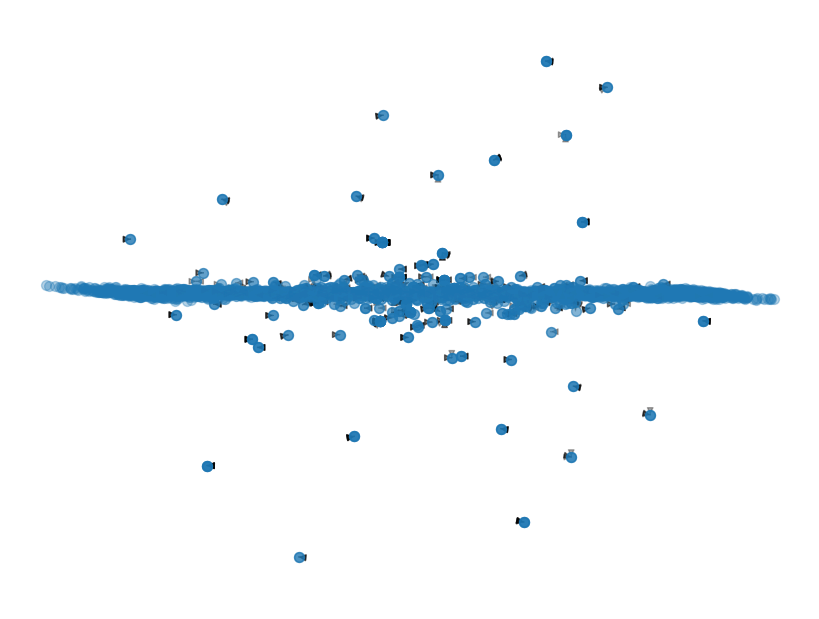

In [269]:
plt.figure(1, figsize=(8,6), dpi=100)
nx.draw_spectral(G, with_labels=False, node_size=50, alpha=0.33)
plt.show()

In [270]:
[len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True) if len(c) > 5]

[52,
 28,
 25,
 25,
 22,
 22,
 19,
 18,
 18,
 16,
 16,
 13,
 12,
 12,
 12,
 11,
 11,
 10,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

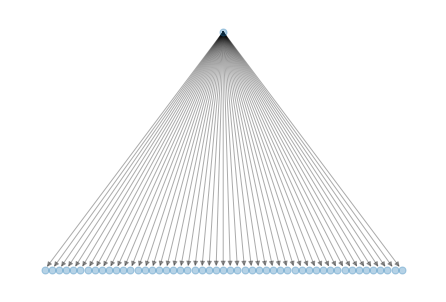

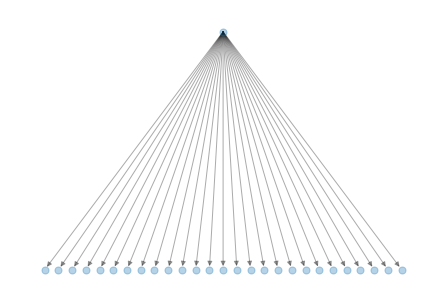

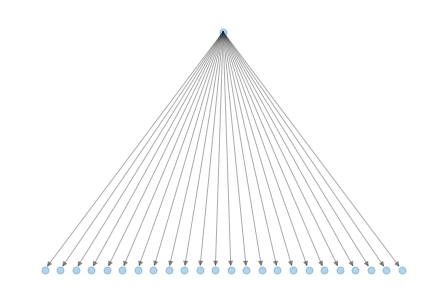

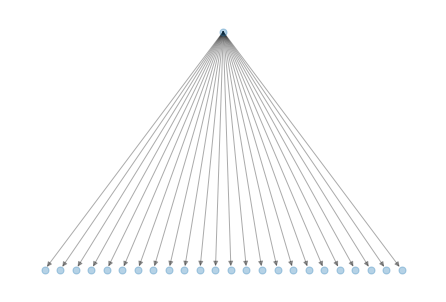

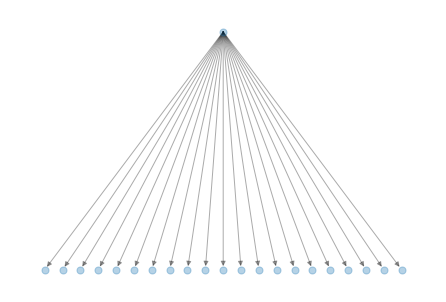

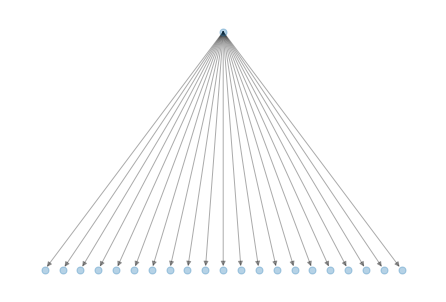

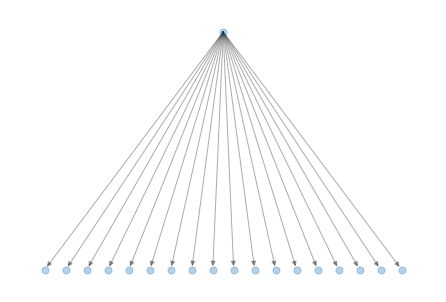

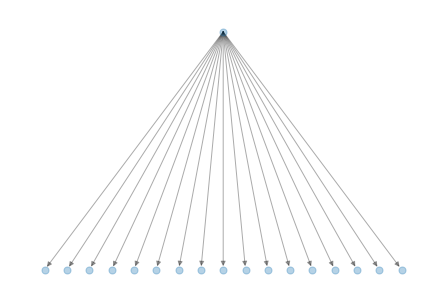

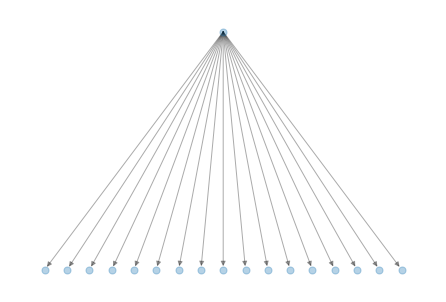

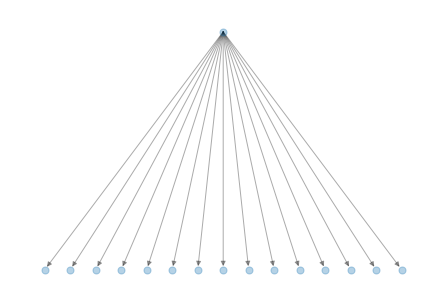

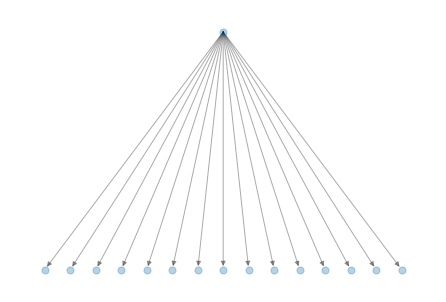

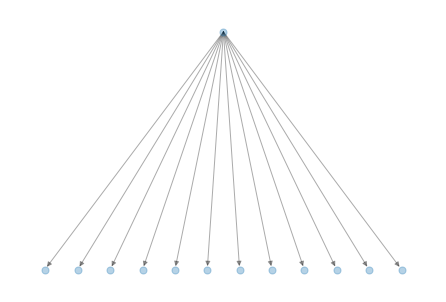

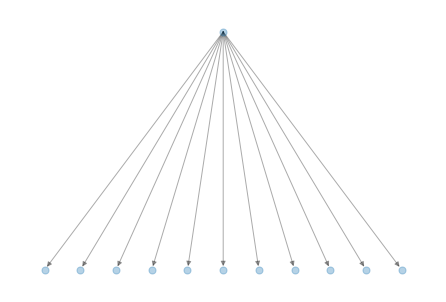

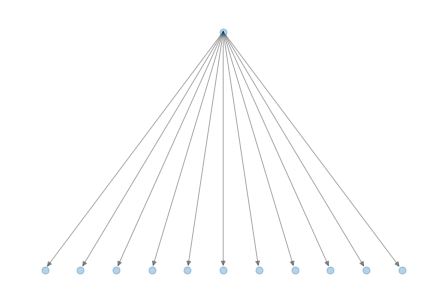

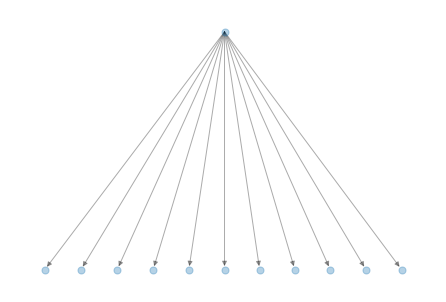

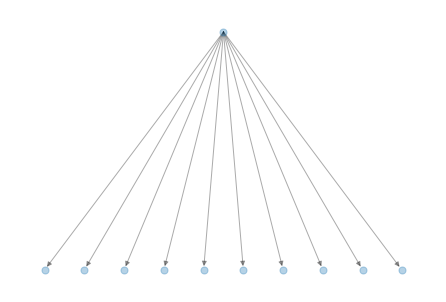

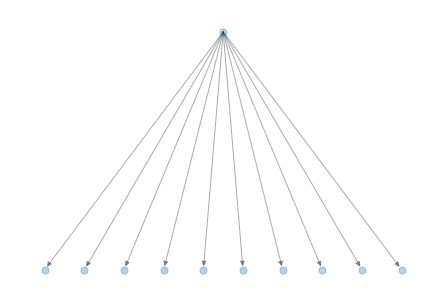

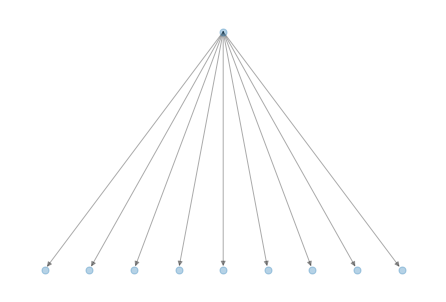

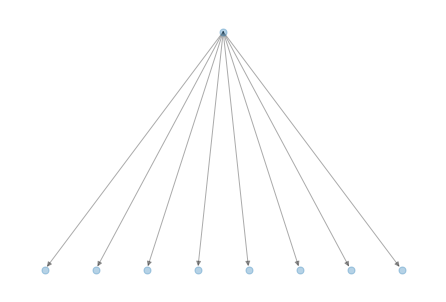

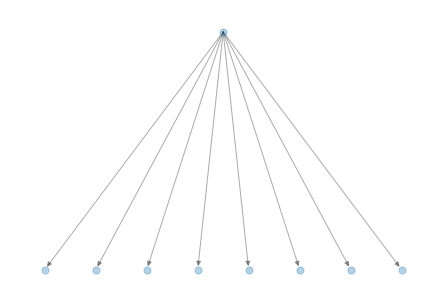

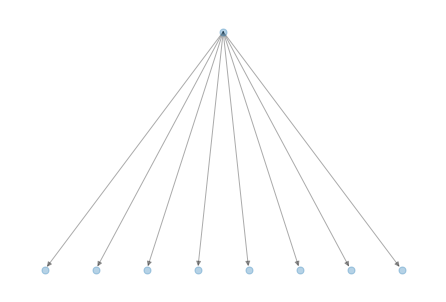

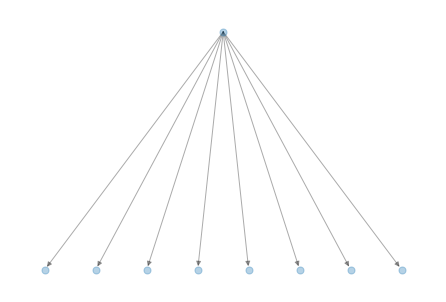

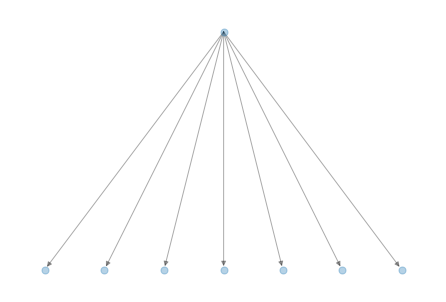

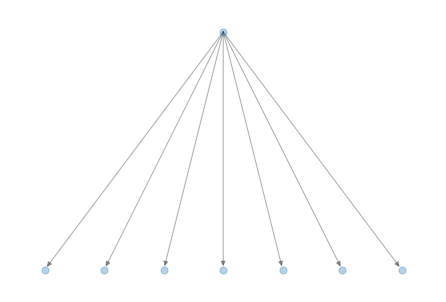

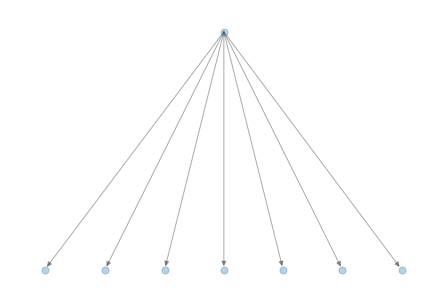

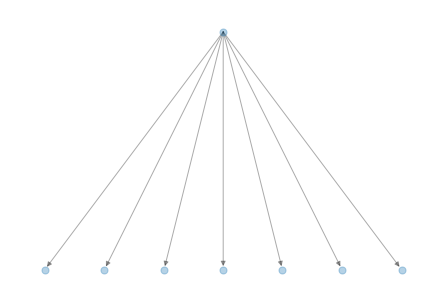

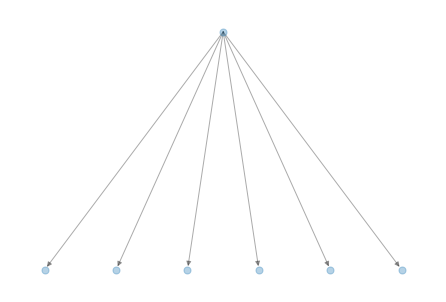

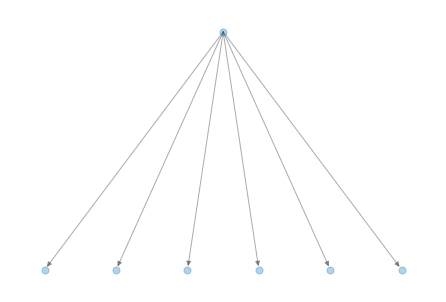

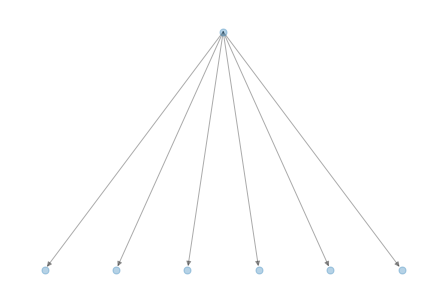

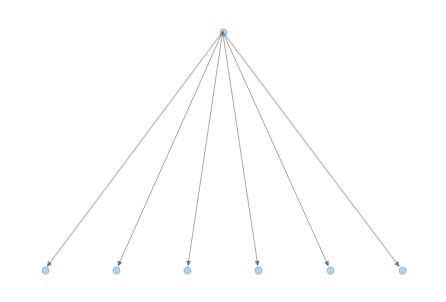

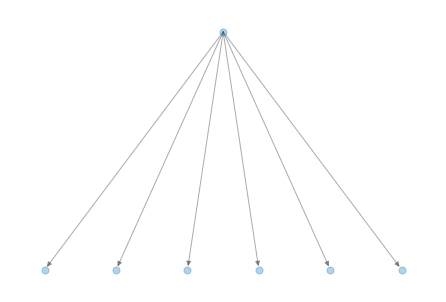

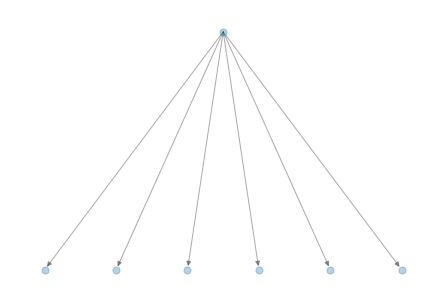

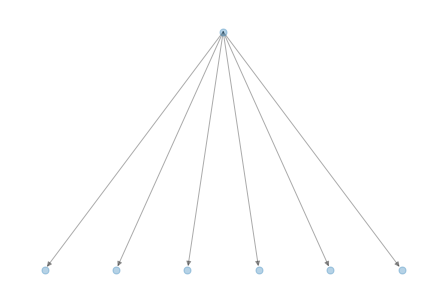

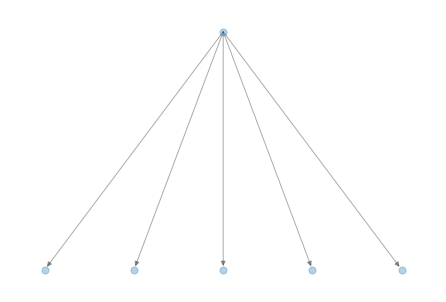

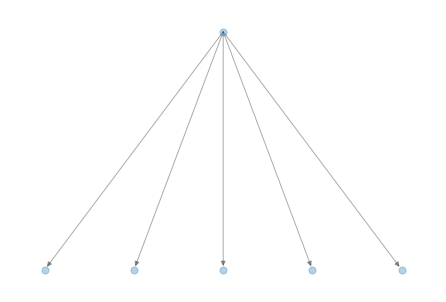

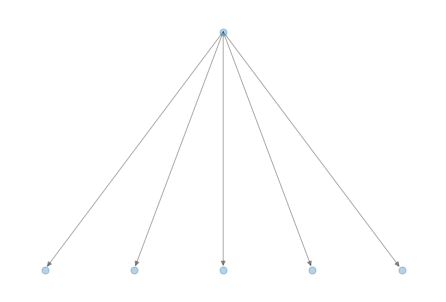

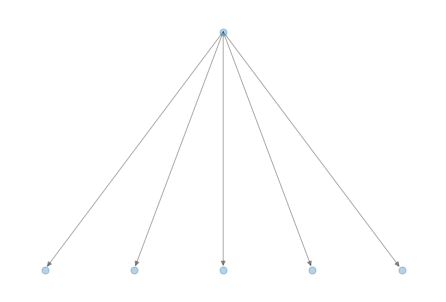

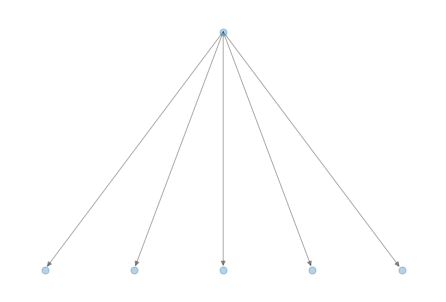

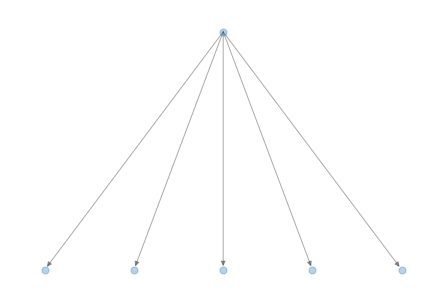

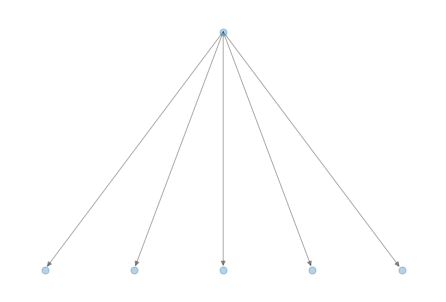

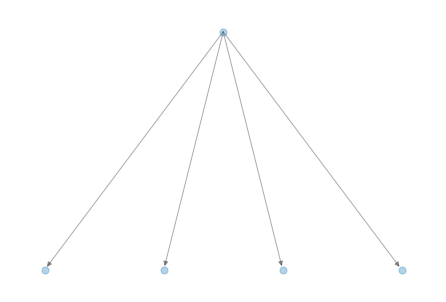

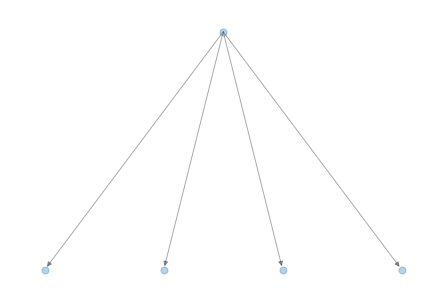

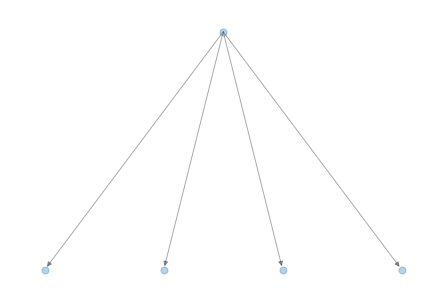

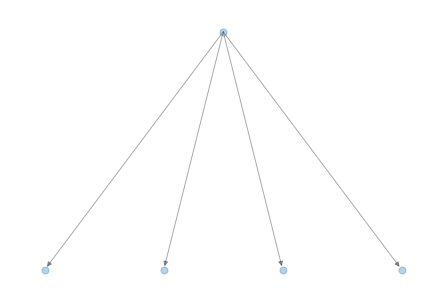

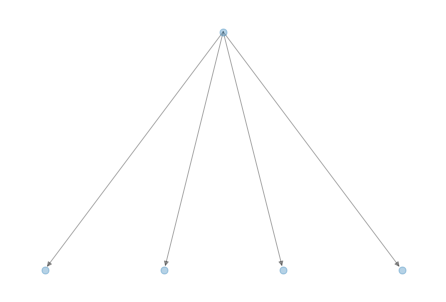

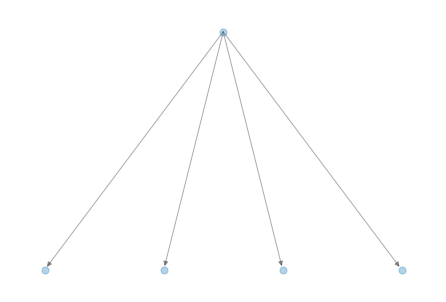

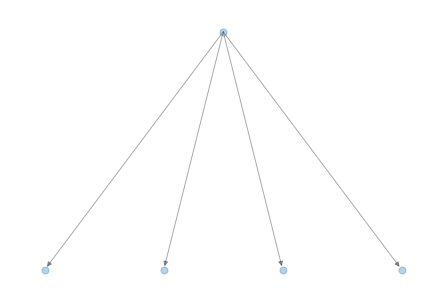

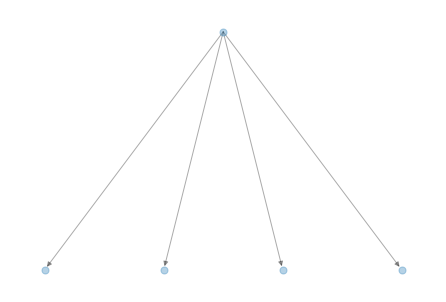

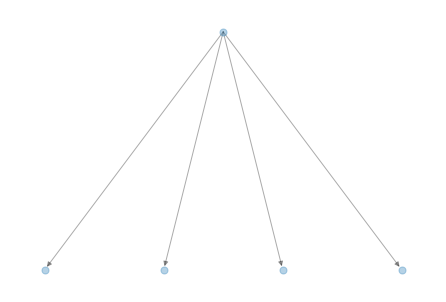

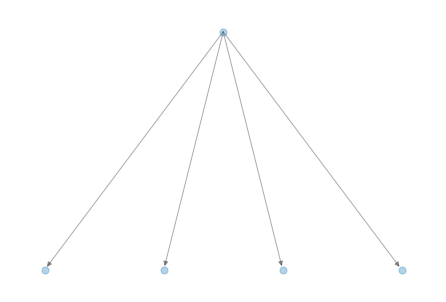

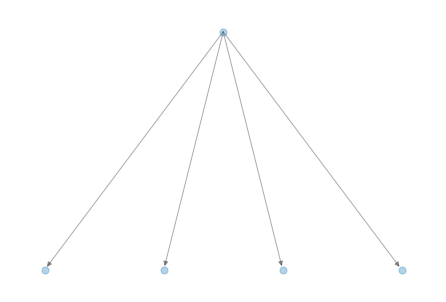

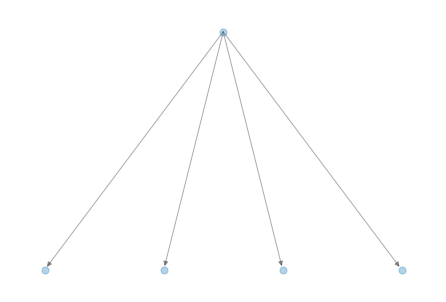

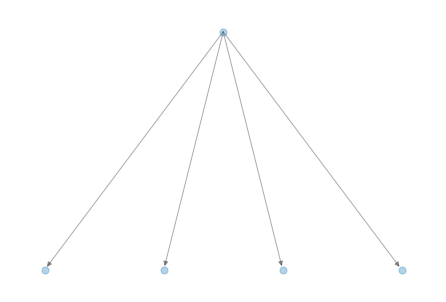

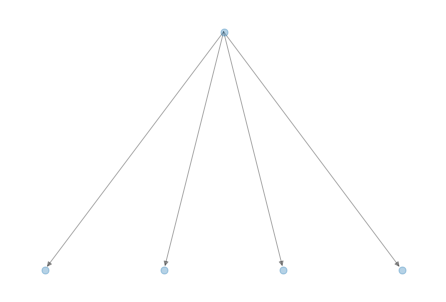

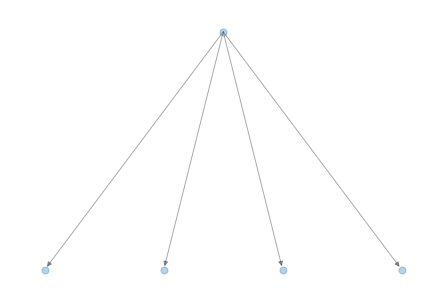

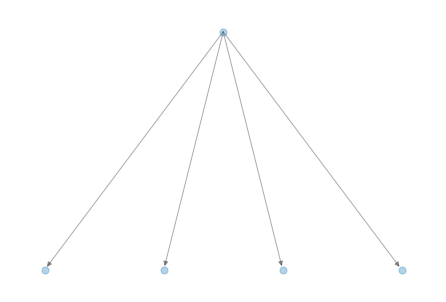

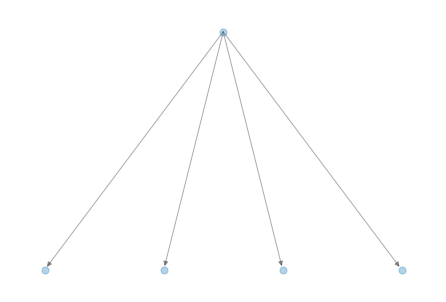

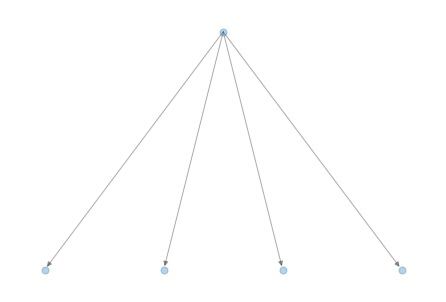

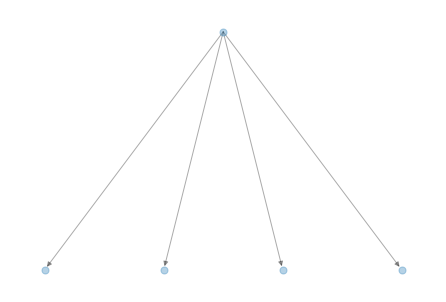

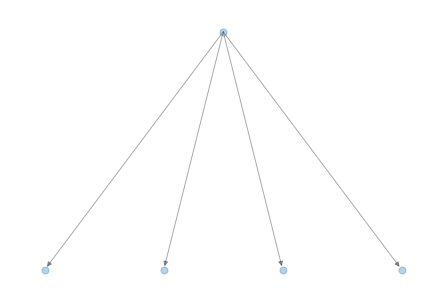

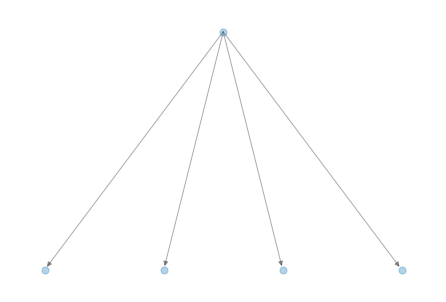

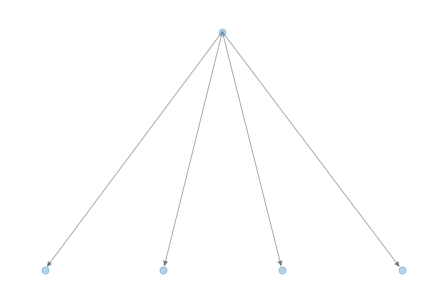

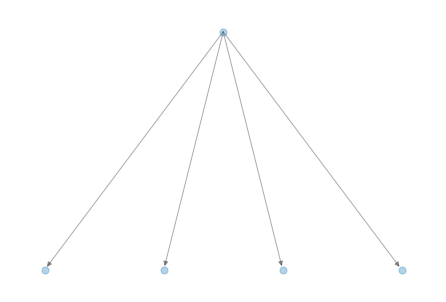

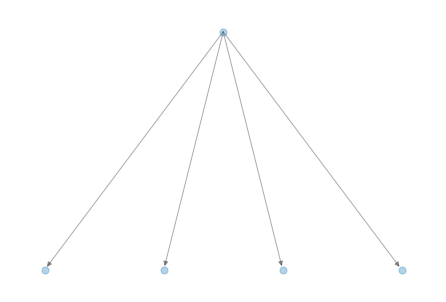

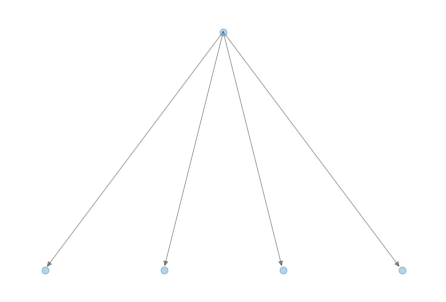

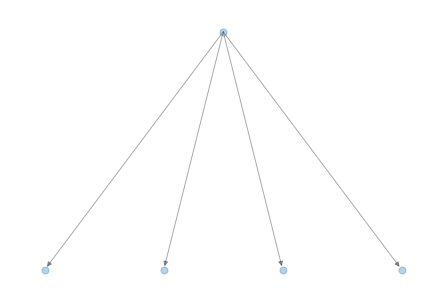

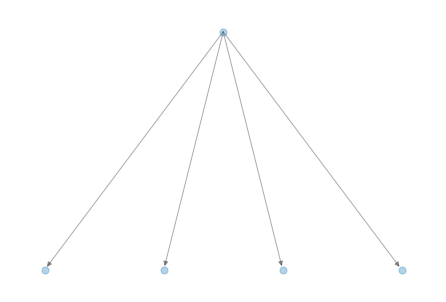

In [271]:
for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True):
    if len(c)>=5:
        g = G.subgraph(c)
        pos = graphviz_layout(g, prog="dot")
        nx.draw(g, pos, node_size=50, alpha=0.33)
        plt.show()